In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
from mmcls.models.builder import build_classifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import cm
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from mmseg.datasets.builder import build_dataset, build_dataloader, DATASETS
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import pandas
import json
import seaborn as sns

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs
from scripts import visualize_cam_results
from scripts.utils.BlurDataset import get_blurred_dataset
from scripts.utils import preprocessing, io
from scripts.utils.model import get_wrongly_classified
from scripts.utils.evaluation import compare_original_blurred, get_eval_metrics
from scripts import evaluate_effectiveness

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
configSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/ocrnet_hr48_512x512_carparts_noflip.py'
checkpointSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth'

segDataPathOriginal = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz'
segDataPathColor = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Color/valAllSegs.npz'
segDataPathWeb = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Web/valAllSegs.npz'
segDataPathStanford = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/StanfordCars_Original/valAllSegs.npz'

paletteName='Comp_Original_Ocrnet_Carparts_Noflip'

segDataPathOG = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz'
segDataPathNoScaleOG = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegsNoScale.npz'
segDataPathNoScaleStanford = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/StanfordCars_Original/valAllSegsNoScale.npz'

camDataGradCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMs.npz'
camDataEigenCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigen.npz'
camDataEigenGrad = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigenGrad.npz'
camDataGradCAMGPU = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGPU.npz'
camDataGradCAMPlusPlus = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGrad++.npz'
camDataLayerCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsLayer.npz'
camDataXCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsXGrad.npz'

imgRootValOriginal = '../data/CompCars_sv_original_split/val'
imgRootValColor = '../data/CompCars_sv_color_split/val'
imgRootValWeb = '../data/CompCars_web_original_split/val'
imgRootValStandford = '../data/StanfordCars_original_split/val'

annfileValOriginal = '../data/CompCars_sv_original_split/meta/val.txt'
annfileValColor = '../data/CompCars_sv_color_split/meta/val.txt'
annfileValWeb = '../data/CompCars_web_original_split/meta/val.txt'
annfileValStanford = '../data/StanfordCars_original_split/meta/val.txt'

dirResOG = 'G:/results/CompCars_original/ResNet'
dirResCol = 'G:/results/CompCars_Color/ResNet'
dirResWeb = 'G:/results/CompCars_Web/ResNet'

dirSwinBaseOG = 'G:/results/CompCars_original/SwinBase'
dirSwinBaseCol = 'G:/results/CompCars_Color/SwinBase'
dirSwinBaseWeb = 'G:/results/CompCars_Web/SwinBase'

dirSwinSmallOG = 'G:/results/CompCars_original/SwinSmall'
dirSwinSmallCol = 'G:/results/CompCars_Color/SwinSmall'
dirSwinSmallWeb = 'G:/results/CompCars_Web/SwinSmall'

configCAMResOriginal = '../CAMModels/resnet/compCars_Original/resnet50_b128x2_compcars-original-split.py'
checkpointCAMResOriginal = '../CAMModels/resnet/compCars_Original/latest.pth'
configCAMResColor = '../CAMModels/resnet/compCars_Color/resnet50_b128x2_compcars-color-split.py'
checkpointCAMResColor = '../CAMModels/resnet/compCars_Color/latest.pth'
configCAMResWeb = '../CAMModels/resnet/compCars_Web/resnet50_b128x2_compcars-web-original-split.py'
checkpointCAMResWeb = '../CAMModels/resnet/compCars_Web/latest.pth'
configCAMResStanford = '../CAMModels/resnet/stanfordCars_Original/resnet50_b128x2_stanford.py'
checkpointCAMResStanford = '../CAMModels/resnet/stanfordCars_Original/latest.pth'

configCAMSwinBaseOriginal = '../CAMModels/swinBase/compCars_Original/swin-base_b128x2_compcars-original-split.py'
checkpointCAMSwinBaseOriginal = '../CAMModels/swinBase/compCars_Original/latest.pth'
configCAMSwinBaseColor = '../CAMModels/swinBase/compCars_Color/swin-base_b128x2_compcars-color-split.py'
checkpointCAMSwinBaseColor = '../CAMModels/swinBase/compCars_Color/latest.pth'
configCAMSwinBaseWeb = '../CAMModels/swinBase/compCars_Web/swin-base_b128x2_compcars-web-original-split.py'
checkpointCAMSwinBaseWeb = '../CAMModels/swinBase/compCars_Web/latest.pth'
configCAMSwinBaseStanford = '../CAMModels/swinBase/stanfordCars_Original/swin-base_b128x2_stanford.py'
checkpointCAMSwinBaseStanford = '../CAMModels/swinBase/stanfordCars_Original/latest.pth'

configCAMSwinSmallOriginal = '../CAMModels/swinSmall/compCars_Original/swin-small_b128x2_compcars-original-split.py'
checkpointCAMSwinSmallOriginal = '../CAMModels/swinSmall/compCars_Original/latest.pth'
configCAMSwinSmallColor = '../CAMModels/swinSmall/compCars_Color/swin-small_b128x2_compcars-color-split.py'
checkpointCAMSwinSmallColor = '../CAMModels/swinSmall/compCars_Color/latest.pth'
configCAMSwinSmallWeb = '../CAMModels/swinSmall/compCars_Web/swin-small_b128x2_compcars-web-original-split.py'
checkpointCAMSwinSmallWeb = '../CAMModels/swinSmall/compCars_Web/latest.pth'
configCAMSwinSmallStanford = '../CAMModels/swinSmall/stanfordCars_Original/swin-small_b128x2_stanford.py'
checkpointCAMSwinSmallStanford = '../CAMModels/swinSmall/stanfordCars_Original/latest.pth'

In [65]:
imgRootBlurredBackground = '../data/CompCars_sv_original_split/blurred/blurredBackground'
evaluate_effectiveness.evaluate_blurred_background(imgRoot=imgRootValOriginal, classifierConfig=configCAMResOG, 
                                                   classifierCheckpoint=checkpointCAMResOG, annfile=annfileValOriginal,
                                                   segData=segDataPathNoScaleOG, segConfig=configSeg, saveImgs=False,
                                                   segCheckpoint=checkpointSeg,  saveDir='compareResults/newLoad',
                                                   eval_data_original='./eval_results_original.json',
                                                   imgRootBlurred=imgRootBlurredBackground)

Evaluating original model vs blurred background.
Evaluating original model vs blurred where segments background are blurred.
Created filtered annotation file at compareResults/newLoad\annfile_filtered.txt
Using standard dataset on blurred data at directory ../data/CompCars_sv_original_split/blurred/blurredBackground
Model already on GPU
Using given evaluation data of original model.
Loading data from Json ./eval_results_original.json
Computing Evaluation Metrics for Blurred Dataset
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 267.7 task/s, elapsed: 50s, ETA:     0s
Saving json data to compareResults/newLoad\eval_results_blurred.json
Add total Change and improvement of original over blurred
Saving evaluation results to compareResults/newLoad\evalBlurred.xlsx
Removing temporary filtered annotation file compareResults/newLoad\annfile_filtered.txt


In [3]:
resultsFile = os.path.join(dirResOG, 'normalized', 
                           'Data_Full_gradCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx')

evaluate_effectiveness.evaluate_blurred_rel_importance(imgRoot=imgRootValOriginal, classifierConfig=configCAMResOG,
                                                      classifierCheckpoint=checkpointCAMResOG, annfile=annfileValOriginal,
                                                      segData=segDataPathNoScaleOG, importanceScoreFile=resultsFile, 
                                                      saveImgs=True, saveDir='pipeline', randomBlur=False,
                                                      eval_data_original='./eval_results_original.json')

Evaluating original model vs blurred relative Importance with top 3 blurred.
Blurring 3 segments out of 19.
Blurring segment with index 10,13,16
Blurring segments front_left_light,hood,tailgate
Evaluating original model vs blurred where segments [10, 13, 16] are blurred.
Created filtered annotation file at pipeline\annfile_filtered.txt
Computing blurred images on demand.
Blurred Images will be saved to pipeline\blurredImgs
Model already on GPU
Using given evaluation data of original model.
Loading data from Json ./eval_results_original.json
Computing Evaluation Metrics for Blurred Dataset
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 19.5 task/s, elapsed: 682s, ETA:     0s
Saving json data to pipeline\eval_results_blurred.json
Add total Change and improvement of original over blurred
Saving evaluation results to pipeline\evalBlurred.xlsx
Removing temporary filtered annotation file pipeline\annfile_filtered.txt


In [6]:
evaluate_effectiveness.evaluate_blurred(imgRoot=imgRootValOriginal, classifierConfig=configCAMResOG, 
                                        classifierCheckpoint=checkpointCAMResOG, annfile=annfileValOriginal,
                                        segData=segDataPathNoScaleOG, segConfig=configSeg, saveImgs=True,
                                        segCheckpoint=checkpointSeg,  saveDir='background_hood_fbumper', 
                                        blurredSegments=['front_bumper','hood','background'],
                                        eval_data_original='./eval_results_original.json')

Evaluating original model vs blurred where segments ['front_bumper', 'hood', 'background'] are blurred.
Created filtered annotation file at background_hood_fbumper\annfile_filtered.txt
Computing blurred images on demand.
Blurred Images will be saved to background_hood_fbumper\blurredImgs
Model already on GPU
Using given evaluation data of original model.
Loading data from Json ./eval_results_original.json
Computing Evaluation Metrics for Blurred Dataset
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 29.0 task/s, elapsed: 460s, ETA:     0s
Saving json data to background_hood_fbumper\eval_results_blurred.json
Add total Change and improvement of original over blurred
Saving evaluation results to background_hood_fbumper\evalBlurred.xlsx
Removing temporary filtered annotation file background_hood_fbumper\annfile_filtered.txt


In [ ]:
generate_segs.main([imgRootValStandford, configSeg, checkpointSeg,
                    '-s', 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/StanfordCars_Original/valAllSegsNoScale'])
# With pipeline
generate_segs.main([imgRootValStandford, configSeg, checkpointSeg, '-p', 'post', configCAMResOG,
                    '-s', 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/StanfordCars_Original/valAllSegs'])

In [8]:
cfgPath = 'C:/Users/Linus/Desktop/mmclassification/configs/resnet/resnet50_8xb32_in1k.py'
checkpointPath = 'C:/Users/Linus/Desktop/mmclassification/configs/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth'
d = generate_cams.main(['cat_dog.jpg', cfgPath, checkpointPath, '-r', 'example_dog', '--method', 'gradcam'])
c = generate_cams.main(['cat_dog.jpg', cfgPath, checkpointPath, '-r', 'example_dog', '--method', 'gradcam', '--target-category', '284'])

Generate Results for file: cat_dog.jpg
Method for CAM generation: gradcam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 3.1 task/s, elapsed: 0s, ETA:     0s
Generate Results for file: cat_dog.jpg
Method for CAM generation: gradcam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 3.0 task/s, elapsed: 0s, ETA:     0s


Generate Results for file: cat_dog.jpg
Method for CAM generation: eigengradcam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 1.4 task/s, elapsed: 1s, ETA:     0s

Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\exampleBoxer.pdf


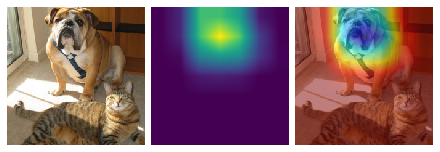

In [7]:
generate_statistics_single.plot_cam(imgPath='cat_dog.jpg', camConfig=cfgPath, camCheckpoint=checkpointPath,
                                   method='eigengradcam', fileName='exampleBoxer')

In [5]:
get_eval_metrics(configCAMResOriginal, checkpointCAMResOriginal, imgRootValOriginal, annfileValOriginal, 
                 saveDir='results/Original', fileName='eval_results_resnet')
get_eval_metrics(configCAMSwinBaseOriginal, checkpointCAMSwinBaseOriginal, imgRootValOriginal, annfileValOriginal, 
                 saveDir='results/Original', fileName='eval_results_swinbase')
get_eval_metrics(configCAMSwinSmallOriginal, checkpointCAMSwinSmallOriginal, imgRootValOriginal, annfileValOriginal, 
                 saveDir='results/Original', fileName='eval_results_swinsmall')

get_eval_metrics(configCAMResColor, checkpointCAMResColor, imgRootValColor, annfileValColor, 
                 saveDir='results/Color', fileName='eval_results_resnet')
get_eval_metrics(configCAMSwinBaseColor, checkpointCAMSwinBaseColor, imgRootValColor, annfileValColor, 
                 saveDir='results/Color', fileName='eval_results_swinbase')
get_eval_metrics(configCAMSwinSmallColor, checkpointCAMSwinSmallColor, imgRootValColor, annfileValColor, 
                 saveDir='results/Color', fileName='eval_results_swinsmall')

get_eval_metrics(configCAMResWeb, checkpointCAMResWeb, imgRootValWeb, annfileValWeb, 
                 saveDir='results/Web', fileName='eval_results_resnet')
get_eval_metrics(configCAMSwinBaseWeb, checkpointCAMSwinBaseWeb, imgRootValWeb, annfileValWeb, 
                 saveDir='results/Web', fileName='eval_results_swinbase')
get_eval_metrics(configCAMSwinSmallWeb, checkpointCAMSwinSmallWeb, imgRootValWeb, annfileValWeb, 
                 saveDir='results/Web', fileName='eval_results_swinsmall')

get_eval_metrics(configCAMResStanford, checkpointCAMResStanford, imgRootValStandford, annfileValStanford, 
                 saveDir='results/StanfordCars', fileName='eval_results_resnet')
get_eval_metrics(configCAMSwinBaseStanford, checkpointCAMSwinBaseStanford, imgRootValStandford, annfileValStanford, 
                 saveDir='results/StanfordCars', fileName='eval_results_swinbase')
get_eval_metrics(configCAMSwinSmallStanford, checkpointCAMSwinSmallStanford, imgRootValStandford, annfileValStanford, 
                 saveDir='results/StanfordCars', fileName='eval_results_swinsmall')

Evaluating metrics on model.
Created filtered annotation file at ./annfile_filtered.txt
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 279.7 task/s, elapsed: 48s, ETA:     0s
Saving json data to results/Original\eval_results_resnet.json
Evaluating metrics on model.
Created filtered annotation file at ./annfile_filtered.txt
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 182.5 task/s, elapsed: 73s, ETA:     0s
Saving json data to results/Original\eval_results_swinbase.json
Evaluating metrics on model.
Created filtered annotation file at ./annfile_filtered.txt
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 215.6 task/s, elapsed: 62s, ETA:     0s
Saving json data to results/Original\eval_results_swinsmall.json
Evaluating metrics on model.
Created filtered annotation file at ./annfile_filtered.txt
[>>>>>>>>>>>>>>>>>>>>>>>>] 13379/13379, 287.0 task/s, elapsed: 47s, ETA:     0s
Saving json data to results/Color\eval_results_resnet.json
Evaluating metrics on model.
Created filtered annotation file at ./annfile_fil

Creating all statistics and saving into stats/SwinBaseWebEigenGrad


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000021BED739240>
Traceback (most recent call last):
  File "C:\Users\Linus\anaconda3\envs\mmseg\lib\site-packages\torch\utils\data\dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "C:\Users\Linus\anaconda3\envs\mmseg\lib\site-packages\torch\utils\data\dataloader.py", line 1317, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "C:\Users\Linus\anaconda3\envs\mmseg\lib\site-packages\torch\utils\data\dataloader.py", line 1258, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (self._persistent_workers and shutdown)
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Using given Segmentation Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Web/valAllSegs.npz
Using given CAM Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/CompCars_Web/SwinBase/valAllCAMsEigenGrad.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:130: UserWarning: No pipeline is applied since segData is provided. If pipeline should be applied specify by pipelineCfg parameter.
  warnings.warn('No pipeline is applied since segData is provided. If pipeline should be applied specify '


Accumulating Statistics for given imgNames.
Generate Statistics Data
Generate TotalCAM Stats


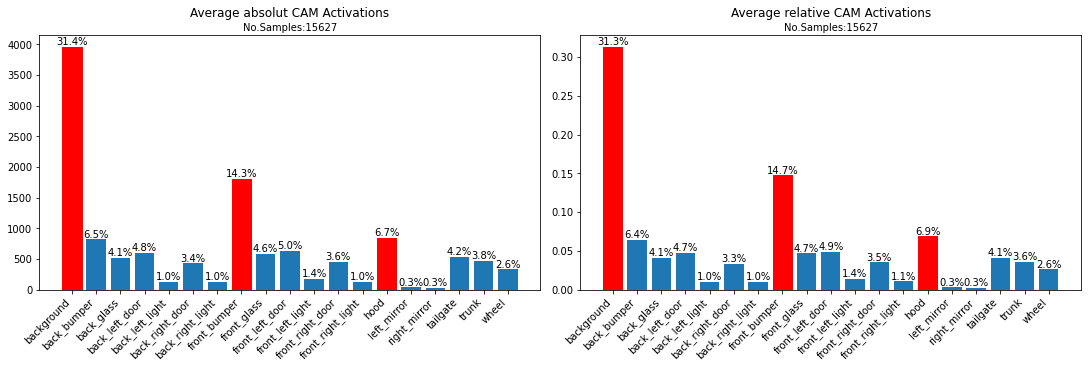

Output path is not a directory. Using base directory: stats/SwinBaseWebEigenGrad.
Saving images to: stats/SwinBaseWebEigenGrad\Multiple_annfile_valAllCAMsEigenGrad_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSegs_16_09_2022.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to stats/SwinBaseWebEigenGrad\Multiple_annfile_valAllCAMsEigenGrad_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSegs_16_09_2022.xlsx.
Using given Segmentation Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Web/valAllSegs.npz
Using given CAM Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/CompCars_Web/SwinBase/valAllCAMsEigenGrad.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:130: UserWarning: No pipeline is applied since segData is provided. If pipeline should be applied specify by pipelineCfg parameter.
  warnings.warn('No pipeline is applied since segData is provided. If pipeline should be applied specify '


Accumulating Statistics for given imgNames.


In [ ]:
igR=imgRootValWeb
clsCfg=configCAMSwinBaseWeb
clsCkp=checkpointCAMSwinBaseWeb
camData='G:/XAI-Vehicle-Classification/preGenData/CompCars_Web/SwinBase/valAllCAMsEigenGrad.npz'
segCfg=configSeg
segCkp=checkpointSeg
segData=segDataPathWeb
svDir='stats/SwinBaseWebEigenGrad'
annfile=annfileValWeb
method='eigengradcam'
vitLike=True
generate_statistics.generate_statistic_collection(imgRoot=igR, classifierConfig=clsCfg, classifierCheckpoint=clsCkp,
                                                  camData=camData, segConfig=segCfg, segCheckpoint=segCkp, segData=segData,
                                                  saveDir=svDir, annfile=annfile, method=method, vitLike=vitLike)